In [1]:
# create config with all the stuff necessary below
from omegaconf import DictConfig, OmegaConf
cfg = OmegaConf.create(
        dict(
            aggregation_method="mean",
            model_name="random_forest",
            model_kwargs=dict(
                numberOfTrees=100,
                minLeafPopulation=3,
                maxNodes=1e4,
            ),
            data=dict(
                aois_test=[f"UKR{i}" for i in range(1, 19) if i not in [1, 2, 3, 4]],
                damages_to_keep=[1, 2],
                extract_winds=["3x3"],  # ['1x1', '3x3', '5x5']
                time_periods={  # to train
                    "pre": ("2020-02-24", "2021-02-23"),  # always only one
                    "post": "3months",
                },
            ),
            inference=dict(
                time_periods={
                    "pre": ("2020-02-24", "2021-02-23"),  # always only one
                    "post": [
                        ("2021-02-24", "2021-05-23"),
                        ("2021-05-24", "2021-08-23"),
                        ("2021-08-24", "2021-11-23"),
                        ("2021-11-24", "2022-02-23"),
                        ("2022-02-24", "2022-05-23"),
                        ("2022-05-24", "2022-08-23"),
                        ("2022-08-24", "2022-11-23"),
                        ("2022-11-24", "2023-02-23"),
                    ],
                },
                quadkey_zoom=8,
            ),
            reducer_names=["mean", "stdDev", "median", "min", "max", "skew", "kurtosis"],
            train_on_all=False,  # train on all damages (train + test split)
            verbose=0,
            export_as_trees=False,
            seed=123,
            run_name="240307",  # must be string
        )
    )

In [2]:
from src.data import quadkeys

In [ ]:
quadkeys.create_ukraine_quadkeys_grid(zoom=cfg.inference.quadkey_zoom) 
# creates quadkeys and saves as file
#TODO need to change the function to accept an additional parameter for country 

In [3]:
# load all quadkeys covering Ukraine
gdf_qk = quadkeys.load_ukraine_quadkeys_grid(zoom=cfg.inference.quadkey_zoom)
gdf_qk 

,qk,area_in_ukraine,geometry
0,12021333,0.002627,"POLYGON ((22.50000 48.92250, 22.42952 48.92250..."
1,12023111,0.111754,"MULTIPOLYGON (((22.50000 48.23949, 22.49739 48..."
2,12030200,0.006700,"POLYGON ((23.60558 51.61802, 23.60563 51.61831..."
3,12030201,0.254635,"MULTIPOLYGON (((25.31250 51.61802, 24.07264 51..."
4,12030202,0.084185,"POLYGON ((23.90625 51.07837, 23.90569 51.07843..."
5,12030203,0.973034,"POLYGON ((25.31250 51.61802, 25.31250 50.73646..."
6,12030210,0.313079,"POLYGON ((26.71875 51.61802, 25.31250 51.61802..."
7,12030211,0.062776,"MULTIPOLYGON (((26.71875 51.61802, 26.71875 51..."
8,12030212,1.000000,"POLYGON ((25.31250 50.73646, 26.71875 50.73646..."
9,12030213,0.977052,"POLYGON ((28.12500 50.73646, 26.71875 50.73646..."


In [4]:
# initialize connection with GEE
import ee
from src.utils.gee import init_gee
init_gee() 

In [5]:
# load trained model from GEE assets
from src.gee.classification.model import load_classifier
asset_id = "projects/rmac-ethz/assets/s1tsdd_Ukraine/240307/classifier_3months_100trees"
classifier = load_classifier(asset_id) #load trained classifier (by olivier) from GEE assets

In [6]:
from typing import List
from tqdm import tqdm

from src.gee.constants import ASSETS_PATH
from src.gee.classification.inference import predict_geo
# from src.utils.gdrive import get_files_in_folder #TODO had to remove this bc linked to pydrive

def predict_and_export_all_grids(
    classifier: ee.Classifier,
    cfg: DictConfig,
    folder: str,
    ids: List[str] = None,
    n_limit: int = None,
    verbose: int = 0,
):
    """
    Predict and export for all grids (quadkeys) in Ukraine.

    If ids is not None, predict only these grids. If n_limit is given, only predict on n_limit grids.
    """

    # Get all grids
    print(f"Predicting for quadkey grid with zoom {cfg.inference.quadkey_zoom}")
    grids = ee.FeatureCollection(ASSETS_PATH + f"s1tsdd_Ukraine/quadkeys_grid_zoom{cfg.inference.quadkey_zoom}")

    if ids is None:
        # No IDs were given, we predict on all (or n_limit if given)
        if n_limit:
            # For debugging
            grids = grids.limit(n_limit)
        ids = grids.aggregate_array("qk").getInfo()
    else:
        # make sure ids are strings
        ids = [str(id_) for id_ in ids]

    # Filter IDs that have already been predicted (names are qk_12345678.tif for instance) #TODO removed bc reliant on pydrive which doesnt work atm
    # files = get_files_in_folder(folder, return_names=True)
    # existing_names = [f.split(".")[0] for f in files if f.startswith("qk_")]
    # ids = [id_ for id_ in ids if id_ not in existing_names]

    # get operations still running
    def get_description(id_):
        return f"{cfg.run_name}_qk{id_}_{'_'.join(cfg.inference.time_periods.post)}"

    ops = [o for o in ee.data.listOperations() if o["metadata"]["state"] in ["PENDING", "RUNNING"]]
    ids_running = [o["metadata"]["description"] for o in ops]
    ids = [id_ for id_ in ids if get_description(id_) not in ids_running]

    print(f"Predicting and exporting {len(ids)} grids")
    for id_ in tqdm(ids):

        grid = grids.filter(ee.Filter.eq("qk", id_))
        preds = predict_geo(
            grid.geometry(),
            classifier,
            cfg.inference.time_periods,
            cfg.data.extract_winds,
            cfg.reducer_names,
            orbits=None,
            verbose=verbose,
        )
        preds = preds.set("qk", id_)

        name = f"qk_{id_}"
        task = ee.batch.Export.image.toDrive(
            image=preds.multiply(2**8 - 1).toUint8(),  # multiply by 255 and convert to uint8
            description=get_description(id_),
            folder=folder,
            fileNamePrefix=name,
            region=grid.geometry(),
            scale=10,
            maxPixels=1e13,
        )
        task.start()

In [7]:
# from src.gee.classification.ukraine_full_prediction import predict_and_export_all_grids #TODO atm use function from above instead that doesnt rely on pydrive
# TODO incl. creating separate folders etc. for different quadkeys BUT atm cannot download client id - solved this for now by creating folders manually
# from src.utils.gdrive import create_drive_folder, create_yaml_file_in_drive_from_config_dict
base_folder_name = f"{cfg.run_name}_quadkeys_predictions"
# try:
#     # Create drive folder and save config
#     create_drive_folder(base_folder_name)
#     create_yaml_file_in_drive_from_config_dict(cfg, base_folder_name)
# except Exception:
#     # get input from user to be sure they want to continue
#     print("Folder already exists. Continue? (y/n)")
#     user_input = input()
#     if user_input != "y":
#         raise ValueError("Interrupted")

post_periods = cfg.inference.time_periods.post

for post_period in post_periods:

    folder_name = f"{base_folder_name}/{'_'.join(post_period)}"
    cfg.inference.time_periods.post = post_period
    # try:
    #         # Create drive folder and save config
    #     create_drive_folder(folder_name)
    # except Exception:
    #         # get input from user to be sure they want to continue
    #     print("Folder already exists. Continue? (y/n)")
    #     user_input = input()
    #     if user_input != "y":
    #         raise ValueError("Interrupted")

        # Launch predictions
    predict_and_export_all_grids(
        classifier=classifier,
        cfg=cfg,
        folder=folder_name.split("/")[-1], 
        ids=None,
        n_limit=None,
        verbose=cfg.verbose,
    )

Predicting for quadkey grid with zoom 8
Predicting and exporting 87 grids


100%|██████████| 87/87 [00:43<00:00,  1.98it/s]


Predicting for quadkey grid with zoom 8
Predicting and exporting 87 grids


100%|██████████| 87/87 [00:41<00:00,  2.08it/s]


Predicting for quadkey grid with zoom 8
Predicting and exporting 85 grids


100%|██████████| 85/85 [00:34<00:00,  2.45it/s]


Predicting for quadkey grid with zoom 8
Predicting and exporting 87 grids


100%|██████████| 87/87 [00:33<00:00,  2.58it/s]


Predicting for quadkey grid with zoom 8
Predicting and exporting 87 grids


100%|██████████| 87/87 [00:32<00:00,  2.66it/s]


Predicting for quadkey grid with zoom 8
Predicting and exporting 87 grids


100%|██████████| 87/87 [00:37<00:00,  2.30it/s]


Predicting for quadkey grid with zoom 8
Predicting and exporting 85 grids


100%|██████████| 85/85 [00:35<00:00,  2.38it/s]


Predicting for quadkey grid with zoom 8
Predicting and exporting 87 grids


100%|██████████| 87/87 [00:34<00:00,  2.49it/s]


In [ ]:
#TODO: stitch quadkeys back together / link them with UNOSAT labels in order to evaluate them 
#might make sense to put them into a geodatabase -> have in different tables the links with admin regions, AOIs, and buildings maybe? 

In [10]:
from src.postprocessing.utils import read_fp_within_geo 
from src.constants import PREDS_PATH
from src.utils.geometry import load_country_boundaries

ukr_geo = load_country_boundaries("Ukraine")
fp = PREDS_PATH / cfg.run_name / "qk_12021333.tif"
preds_arr = read_fp_within_geo(fp, ukr_geo)
preds_arr

<xarray.DataArray (band: 1, y: 473, x: 597)>
[282381 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 22.44 22.44 22.44 22.44 ... 22.49 22.49 22.49 22.49
  * y            (y) float64 48.96 48.96 48.96 48.96 ... 48.92 48.92 48.92 48.92
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    long_name:      classification

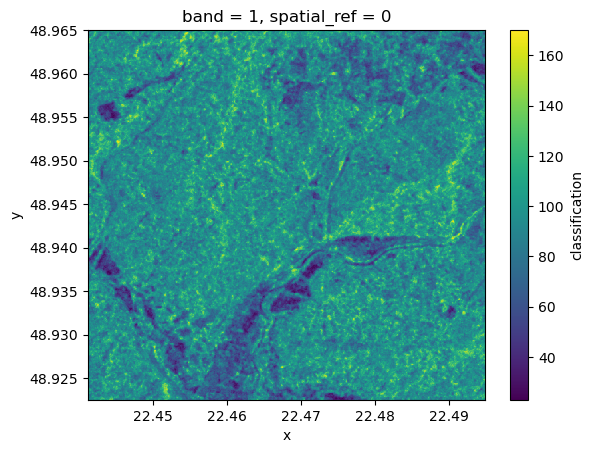

In [11]:
preds_arr.plot()